In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dechorate import constants
from dechorate.utils.file_utils import load_from_pickle

# Load RIRs

In [2]:
path_to_rirs_hdf = Path('..', 'dEchorate_rirs.hdf5')
rir_dset = h5py.File(path_to_rirs_hdf, mode='r')

signals = list(rir_dset.keys())
print('Signals', signals)

rooms = list(rir_dset[signals[0]].keys())
print('Rooms', rooms)

sources = list(rir_dset[signals[0]][rooms[0]].keys())
print(sources)

Signals ['rir']
Rooms ['000000', '000001', '000010', '000100', '001000', '010000', '011000', '011100', '011110', '011111', '020002']
['1', '2', '3', '4', '5', '6', '7', '8', '9']


In [58]:
Fs = constants['Fs']
R = len(rooms)
J = len(sources)
I = 30
L = int(constants['Fs'])
rirs = np.zeros([L, I, J, R])


for r, room in enumerate(rooms):

    srcs = list(rir_dset['rir'][room])

    for j, src in enumerate(srcs):

        group = f'/rir/{room}/{src}'
        data = np.asarray(rir_dset[group])
    
        rirs[:, :, j, r] = data[:L,:-1]

In [59]:
J = 6 # 4+2 directional (not the 3 omni)
I = 30 # leave the loopback out
L = Fs//6 # just the first echoes
rirs = rirs[:L, :I, :J, :]
L, I, J, R = rirs.shape

In [61]:
## load annotation
echo_note = load_from_pickle('../outputs/dEchorate_echo_notes.pkl')
# old_echo_note = load_from_pickle('/home/chutlhu/Documents/Datasets/dEchorate/raw/processed/mics_srcs_echo_annotation.pkl')

mics = echo_note['mics']
srcs = echo_note['srcs']

toa = np.sort(echo_note['toa'][:,:I,:J], axis=0)
print(toa.shape)


(25, 30, 6)


(8000, 180)


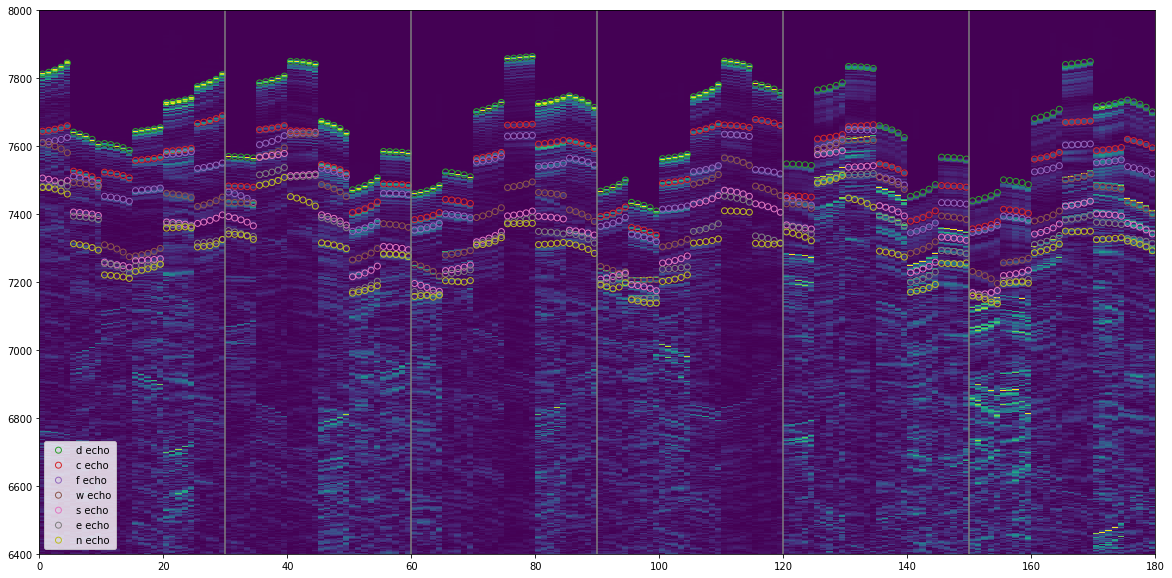

In [62]:
## SKYLINE WITH NEW ESTIMATED IMAGES
rirs_skyline = np.abs(rirs[:,:,:,-2]).transpose([0, 2, 1]).reshape([L, I*J])
rirs_skyline = rirs_skyline / np.max(np.abs(rirs_skyline), axis=0)
print(rirs_skyline.shape)

plt.figure(figsize=(20,10))
plt.imshow(rirs_skyline, extent=[0, I*J, 0, L], aspect='auto', interpolation='nearest')

# plot srcs boundaries
for j in range(J):
    plt.axvline(j*I, color='C7')

walls = ['d', 'c', 'f', 'w', 's', 'e', 'n']

for k in range(len(walls)):
    wall = walls[k]
    plt.scatter(np.arange(I*J)+0.5, L - toa[k, :, :].T.flatten()*Fs, marker='o',
                facecolors='none', edgecolors='C%d' % (k+2), label='%s echo' % wall)

plt.ylim([L-1600, L])
plt.xlim([0, I*J])
plt.legend()
plt.show()